In [ ]:
code_file= 'sum.c'
flags =  ['-O0', '-O1', '-O2', '-O3', '-Os', '-Ofast', '-Og', '-fno-inline']
deque = "N"

In [ ]:
import subprocess

def check_compatible_flags(code_path, flags):
    compatible_flags = []
    non_compatible_flags = []


    for flag in flags:
        compile_command = f"gcc {code_path} {flag} -o output"
        try:
            compile_result = subprocess.run(compile_command, shell=True, capture_output=True, text=True, timeout=10)
            print("result = ", flag + " ---> ", compile_result.stderr)
            if compile_result.returncode == 0:
                compatible_flags.append(flag)
            else:
                error_message = compile_result.stderr

                non_compatible_flags.append(flag)
        except subprocess.TimeoutExpired:
            non_compatible_flags.append(flag)

    return compatible_flags, non_compatible_flags


# Path to the new C file you want to test
new_code_path = code_file  # Change this to the path of your new code

# Check and print compatible and non-compatible flags
compatible_flags, non_compatible_flags = check_compatible_flags(new_code_path, flags)

print("Compatible GCC Flags:")
print(compatible_flags)
print("\nNon-Compatible GCC Flags:")
print(non_compatible_flags)

result =  -O0 --->  
result =  -O1 --->  
result =  -O2 --->  
result =  -O3 --->  
result =  -Os --->  
result =  -Ofast --->  
result =  -Og --->  
result =  -fno-inline --->  
Compatible GCC Flags:
['-O0', '-O1', '-O2', '-O3', '-Os', '-Ofast', '-Og', '-fno-inline']

Non-Compatible GCC Flags:
[]


In [ ]:
class CompilerEnv:
    def __init__(self, code_path):
        self.code_path = code_path
        self.flags = compatible_flags
        self.state_space = len(self.flags)
        self.action_space = len(self.flags)
        self.current_state = tuple([0] * self.state_space)

    def reset(self):
        self.current_state = tuple([0] * self.state_space)
        return self.current_state

    def compile_and_measure(self, flags):
        flags_str = ' '.join([self.flags[i] for i, flag in enumerate(flags) if flag])
        compile_command = f"gcc {self.code_path} {flags_str} -o output"
        run_command = "./output"

        try:
            compile_result = subprocess.run(compile_command, shell=True, capture_output=True, text=True, timeout=10)
            if compile_result.returncode != 0:
                print("Compilation failed:", compile_result.stderr)
                return float('inf')

            subprocess.run(f"chmod +x output", shell=True)

            run_result = subprocess.run(run_command, shell=True, capture_output=True, text=True, timeout=10)
            if run_result.returncode != 0:
                print("Execution failed:", run_result.stderr)
                return float('inf')

            output_lines = run_result.stdout.strip().split('\n')
            execution_time = float(output_lines[-1])
            return execution_time

        except subprocess.TimeoutExpired:
            print("Execution timed out")
            return float('inf')

    def step(self, action):
        current_flags = list(self.current_state)
        current_flags[action] = 1 - current_flags[action]
        self.current_state = tuple(current_flags)

        execution_time = self.compile_and_measure(self.current_state)
        reward = -execution_time

        return self.current_state, reward, False

    def render(self):
        print(f"State: {self.current_state}")


#Sarasa

Q-table loaded.
Episode 1/100, Rewards per episode: -0.34726799999999897, Min Reward: -0.02725599999999999897837277273993095150217413902283 (State: (0, 0, 0, 0, 0, 0, 0, 0)), Max Reward: -0.00000099999999999999995474811182588625868561393872 (State: (1, 0, 0, 1, 0, 0, 0, 0)), Average Reward: -0.0034726799999999993
Episode 2/100, Rewards per episode: -0.1381110000000001, Min Reward: -0.03424200000000000160271795834887598175555467605591 (State: (0, 0, 0, 0, 0, 0, 0, 1)), Max Reward: -0.00000000000000000000000000000000000000000000000000 (State: (1, 1, 1, 1, 0, 1, 0, 1)), Average Reward: -0.0013811100000000005
Episode 3/100, Rewards per episode: -0.03707000000000004, Min Reward: -0.00766200000000000040756287233989496598951518535614 (State: (0, 1, 1, 1, 1, 1, 1, 1)), Max Reward: -0.00000000000000000000000000000000000000000000000000 (State: (1, 1, 0, 0, 1, 0, 0, 1)), Average Reward: -0.0003707000000000001
Episode 4/100, Rewards per episode: -0.05145200000000009, Min Reward: -0.007400000000000

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Q-table saved.


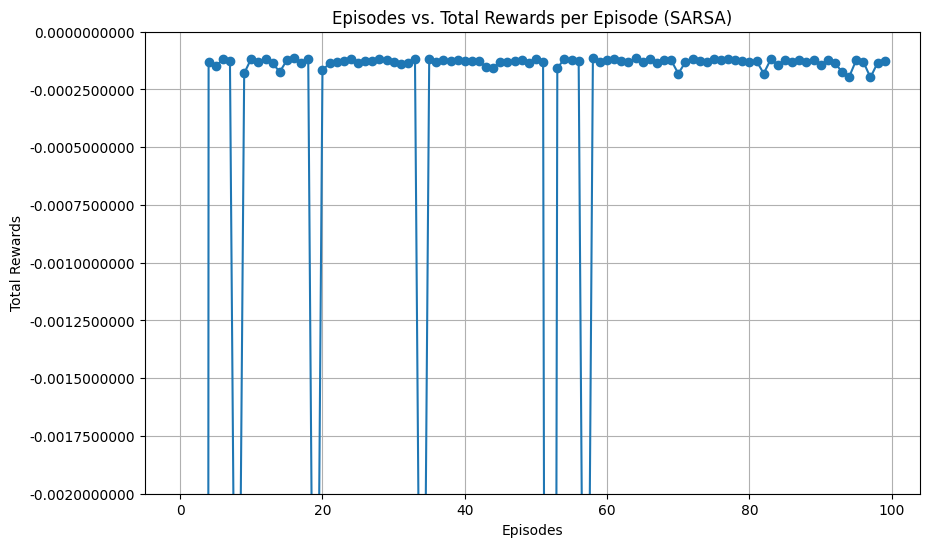

In [ ]:
import numpy as np
import subprocess
import pickle
import os
from collections import deque
import random
import matplotlib.pyplot as plt
from google.colab import files

class SARSAAgent:
    def __init__(self, state_space, action_space, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0,
                 exploration_decay=0.99, q_table_file='sarsa_q_table.pkl'):
        self.state_space = state_space
        self.action_space = action_space
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.q_table_file = q_table_file
        self.q_table = self.load_q_table()

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state_actions = self.q_table.get(state, np.zeros(self.action_space))
            action = np.argmax(state_actions)
        return action

    def learn(self, state, action, reward, next_state, next_action):
        if state not in self.q_table:
            self.q_table[state] = np.ones(self.action_space)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(self.action_space)

        predict = self.q_table[state][action]
        target = reward + self.gamma * self.q_table[next_state][next_action]
        self.q_table[state][action] += self.lr * (target - predict)
        self.epsilon *= self.epsilon_decay

    def save_q_table(self):
        with open(self.q_table_file, 'wb') as f:
            pickle.dump(self.q_table, f)
        files.download(self.q_table_file)
        print("Q-table saved.")

    def load_q_table(self):
        if os.path.exists(self.q_table_file):
            with open(self.q_table_file, 'rb') as f:
                print("Q-table loaded.")
                return pickle.load(f)
        else:
            return {}

def train_sarsa(agent, env, episodes=100):
    rewards = []

    for episode in range(episodes):
        state = env.reset()
        action = agent.choose_action(state)
        total_reward = 0
        episode_rewards = []
        episode_states = []

        for step in range(100):
            next_state, reward, done = env.step(action)
            next_action = agent.choose_action(next_state)
            agent.learn(state, action, reward, next_state, next_action)
            state = next_state
            action = next_action
            total_reward += reward
            episode_rewards.append(reward)
            episode_states.append(state)

            if done:
                break

        rewards.append(total_reward)
        min_reward = min(episode_rewards)
        max_reward = max(episode_rewards)
        avg_reward = np.mean(episode_rewards)
        min_state = episode_states[episode_rewards.index(min_reward)]
        max_state = episode_states[episode_rewards.index(max_reward)]

        print(f"Episode {episode + 1}/{episodes}, Rewards per episode: {total_reward}, Min Reward: {min_reward:.50f} (State: {min_state}), Max Reward: {max_reward:.50f} (State: {max_state}), Average Reward: {avg_reward}")

    agent.save_q_table()

    plt.figure(figsize=(10, 6))
    plt.plot(range(episodes), rewards, marker='o', linestyle='-')
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards')
    plt.title('Episodes vs. Total Rewards per Episode (SARSA)')
    plt.ylim(-0.002, 0)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.10f}'))
    plt.grid(True)
    plt.show()


new_code_path = 'sum.c'  # Specify the path to your C program
env = CompilerEnv(new_code_path)
sarsa_agent = SARSAAgent(env.state_space, env.action_space)

train_sarsa(sarsa_agent, env)



SARSA is an on-policy reinforcement learning algorithm. This means that it learns the value of the policy that it is currently using to make decisions. Unlike Q-learning, which updates its estimates using the maximum reward of the next state, SARSA updates its estimates using the action actually taken in the next state.

**On-Policy Learning:** The algorithm updates Q-values based on the policy being used (hence the name SARSA: State-Action-Reward-State-Action).

**Epsilon-Greedy Policy:** Like Q-learning, SARSA uses an epsilon-greedy policy to balance exploration and exploitation.

**Q-Value Update:** The Q-value update is based on the actual action taken, not the optimal action. This makes SARSA suitable for environments where following the policy is important.

# DQn

**Overview of DQN**

A Deep Q-Network (DQN) is an extension of Q-learning where a neural network is used to approximate the Q-value function. This is particularly useful when dealing with large or continuous state spaces, where a tabular representation would be impractical.


The key components of the DQN are:


**Neural Network:** Used to approximate Q-values.

**Experience Replay:** A technique to stabilize learning by breaking correlation in training data.

**Target Network:** A separate network to compute target Q-values, providing more stable training targets.

**Epsilon-Greedy Strategy: **Balances exploration and exploitation during training.

Episode 1/100, Total Reward: -0.4084429999999998, Min Reward: -0.0334680000, Max Reward: -0.0000010000, Average Reward: -0.00408443
Episode 2/100, Total Reward: -0.30410999999999944, Min Reward: -0.0344830000, Max Reward: -0.0000000000, Average Reward: -0.0030410999999999997
Episode 3/100, Total Reward: -0.3643269999999999, Min Reward: -0.0339730000, Max Reward: -0.0000010000, Average Reward: -0.00364327
Episode 4/100, Total Reward: -0.4412119999999994, Min Reward: -0.0077640000, Max Reward: -0.0000010000, Average Reward: -0.004412119999999999
Episode 5/100, Total Reward: -0.4985549999999991, Min Reward: -0.0346860000, Max Reward: -0.0000010000, Average Reward: -0.00498555
Episode 6/100, Total Reward: -0.41016999999999976, Min Reward: -0.0344180000, Max Reward: -0.0000000000, Average Reward: -0.0041017
Episode 7/100, Total Reward: -0.37828199999999945, Min Reward: -0.0081220000, Max Reward: -0.0000010000, Average Reward: -0.003782819999999999
Episode 8/100, Total Reward: -0.662196, Min

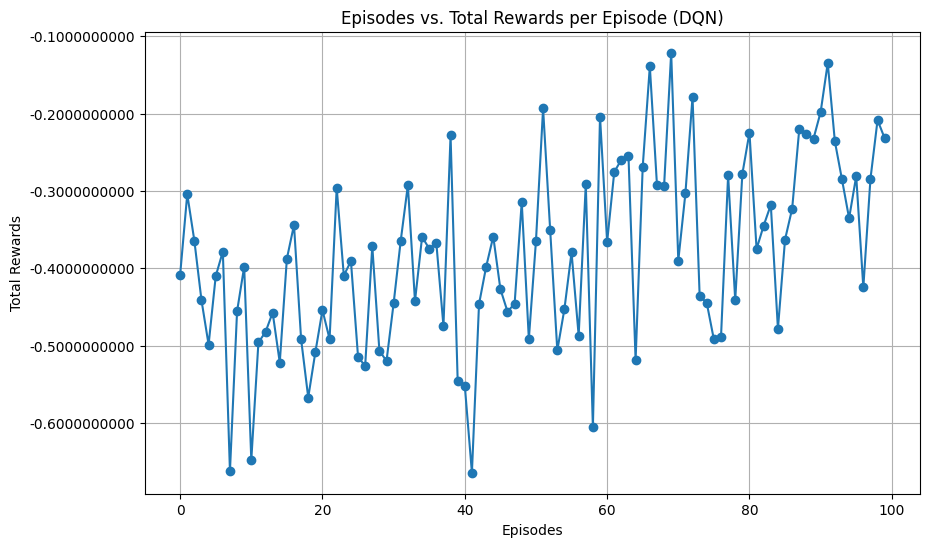

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Define the neural network used for DQN
class DQNetwork(nn.Module):
    def __init__(self, state_space, action_space):
        super(DQNetwork, self).__init__()
        # A simple feedforward neural network with two hidden layers
        self.fc1 = nn.Linear(state_space, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_space)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# DQN agent class
class DQNAgent:
    def __init__(self, state_space, action_space, learning_rate=0.001, discount_factor=0.99, exploration_rate=1.0,
                 exploration_decay=0.995, memory_size=1000, batch_size=32, target_update_frequency=10):
        self.state_space = state_space
        self.action_space = action_space
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size

        # Initialize the main and target networks
        self.model = DQNetwork(state_space, action_space)
        self.target_model = DQNetwork(state_space, action_space)
        self.update_target_network()

        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

        self.target_update_frequency = target_update_frequency
        self.steps_done = 0

    def choose_action(self, state):
        # Implement epsilon-greedy action selection
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.action_space)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch from the replay buffer
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)

            # Compute the predicted Q-values for the current state
            q_values = self.model(state_tensor)
            q_value = q_values[0, action]

            # Compute the target Q-value
            with torch.no_grad():
                next_q_values = self.target_model(next_state_tensor)
                next_q_value = torch.max(next_q_values)

            # Set the target Q-value for the current action
            target = reward + (1 - done) * self.gamma * next_q_value

            # Compute the loss
            loss = self.loss_fn(q_value, target)

            # Perform a gradient descent step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        # Decay epsilon
        self.epsilon *= self.epsilon_decay

        # Update the target network periodically
        if self.steps_done % self.target_update_frequency == 0:
            self.update_target_network()

        self.steps_done += 1

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

def train_dqn(agent, env, episodes=100):
    rewards = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_rewards = []

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            episode_rewards.append(reward)

            if done:
                break

        agent.replay()
        rewards.append(total_reward)
        min_reward = min(episode_rewards)
        max_reward = max(episode_rewards)
        avg_reward = np.mean(episode_rewards)

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Min Reward: {min_reward:.10f}, Max Reward: {max_reward:.10f}, Average Reward: {avg_reward}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(episodes), rewards, marker='o', linestyle='-')
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards')
    plt.title('Episodes vs. Total Rewards per Episode (DQN)')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.10f}'))
    plt.grid(True)
    plt.show()

# Example of running a DQN experiment
new_code_path = 'sum.c'  # Specify the path to your C program
env = CompilerEnv(new_code_path)
dqn_agent = DQNAgent(env.state_space, env.action_space)

train_dqn(dqn_agent, env)
